# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# The task is to classify the character from the given image

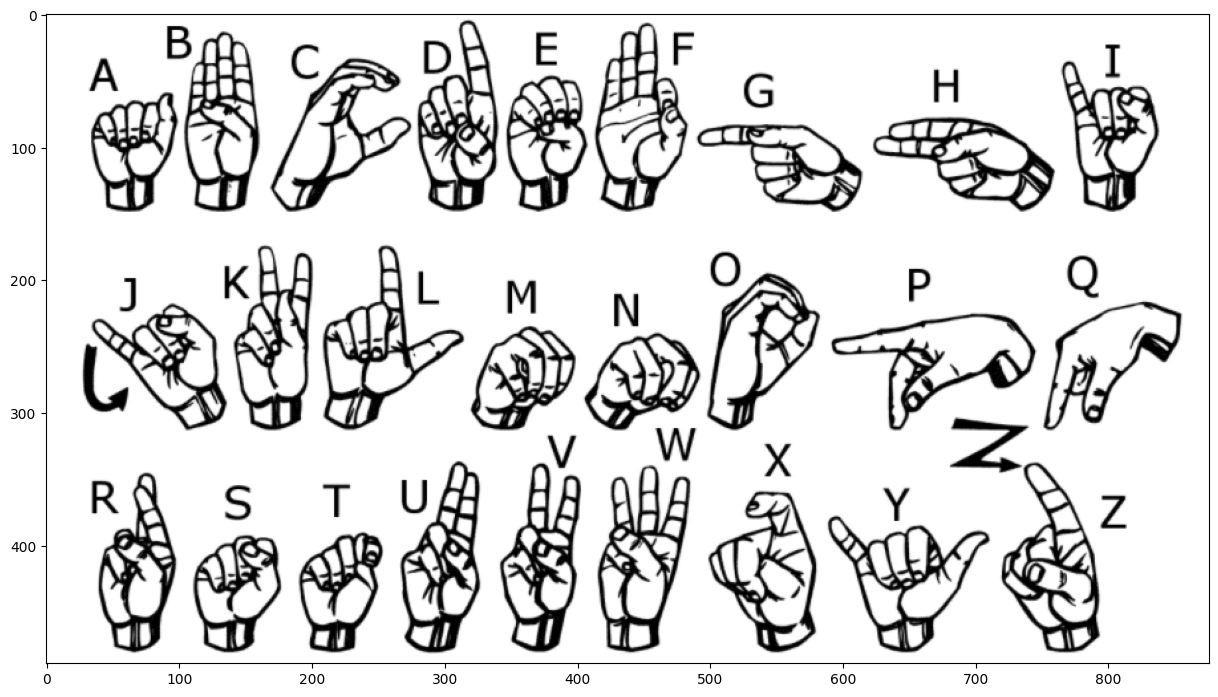

In [4]:
plt.figure(figsize = (15,15))
img = plt.imread('american_sign_language.PNG')
plt.imshow(img)
plt.show()

# Importing Data

In [5]:
train_data = pd.read_csv('sign_mnist_train.csv')
test_data = pd.read_csv('sign_mnist_test.csv')

# Exploring Data

In [6]:
train_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179


In [7]:
test_data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53


# Splitting Data

In [8]:
X_train = train_data.drop('label',axis=1)
X_test = test_data.drop('label',axis=1)
y_train = train_data['label']
y_test = test_data['label']

In [9]:
X_train = X_train.values.reshape(train_data.shape[0],28,28,1)
X_test = X_test.values.reshape(test_data.shape[0],28,28,1)

# Data Normalization

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             width_shift_range=.2,
                             height_shift_range=.2,
                             rotation_range=30,
                             brightness_range=[0.8, 1.2],
                             horizontal_flip=True)

datagenRescale = ImageDataGenerator(rescale=1./255)
X_train = datagen.flow(X_train, y_train, batch_size=128)
X_test = datagenRescale.flow(X_test, y_test)

# Reviewing some examples

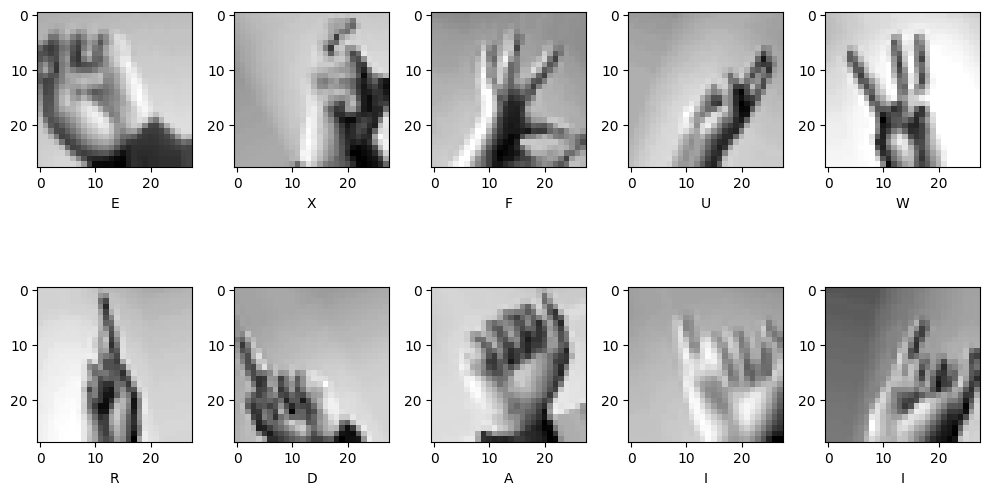

In [11]:
characters = "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    for X,Y in X_train:
        img = X[i]
        plt.imshow(img, cmap='gray')
        plt.xlabel(characters[Y[i]])
        break
plt.tight_layout()
plt.show()

# Applying the callbacks

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint_filepath = 'SL_model.h5'
callback_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=False, monitor='val_accuracy', mode='max', save_best_only=True)
callback_learningrate = ReduceLROnPlateau(monitor='loss', mode='min', min_delta=0.01, patience=3, factor=.75, min_lr=0.00001, verbose=1)
callbacks = [callback_checkpoint, callback_learningrate]

# Model Building & training

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout

Model = Sequential([Conv2D(filters=32,  kernel_size=(3,3), activation="relu", input_shape=(28,28,1)),
                    MaxPool2D(2,2, padding='same'),
                    Dropout(0.2),
                    Conv2D(filters=128,  kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    Dropout(0.2),
                    Conv2D(filters=512, kernel_size=(3,3), activation="relu"),
                    MaxPool2D(2,2, padding='same'),
                    Dropout(0.2),
                    Flatten(),
                    Dense(units=4096, activation="relu"),                 
                    Dropout(0.2),
                    Dense(units=1024, activation="relu"),
                    Dropout(0.2),          
                    Dense(units=256, activation="relu"),
                    Dropout(0.2),
                    Dense(units=25, activation="softmax"),
])

In [14]:
Model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [15]:
Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 128)       36992     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 128)         0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 6, 6, 128)         0

In [18]:
Model.fit(X_train, validation_data=X_test, epochs=20, callbacks=callbacks)

Epoch 1/20
215/215 [==============================] - 120s 561ms/step - loss: 2.3022 - accuracy: 0.2468 - val_loss: 1.4807 - val_accuracy: 0.4410 - lr: 0.0010
Epoch 2/20
215/215 [==============================] - 116s 538ms/step - loss: 1.5819 - accuracy: 0.4436 - val_loss: 0.8783 - val_accuracy: 0.6708 - lr: 0.0010
Epoch 3/20
215/215 [==============================] - 149s 694ms/step - loss: 1.1820 - accuracy: 0.5861 - val_loss: 0.6394 - val_accuracy: 0.7673 - lr: 0.0010
Epoch 4/20
215/215 [==============================] - 152s 704ms/step - loss: 0.9412 - accuracy: 0.6687 - val_loss: 0.3723 - val_accuracy: 0.8663 - lr: 0.0010
Epoch 5/20
215/215 [==============================] - 180s 838ms/step - loss: 0.7834 - accuracy: 0.7264 - val_loss: 0.2630 - val_accuracy: 0.9141 - lr: 0.0010
Epoch 6/20
215/215 [==============================] - 150s 699ms/step - loss: 0.6688 - accuracy: 0.7691 - val_loss: 0.1715 - val_accuracy: 0.9477 - lr: 0.0010
Epoch 7/20
215/215 [==========================

# Accuracy test

In [19]:
score = Model.evaluate(X_test) 

print('Test accuracy:', score[1])

225/225 [==============================] - 4s 18ms/step - loss: 0.0127 - accuracy: 0.9958
Test accuracy: 0.9958170652389526


# Testing the Model

In [21]:
test = pd.read_csv('sign_mnist_test.csv')
y_test = test['label']
test.drop(['label'], axis=1, inplace=True)
X_test = test.values.reshape(test.shape[0],28,28,1)

225/225 [==============================] - 5s 20ms/step


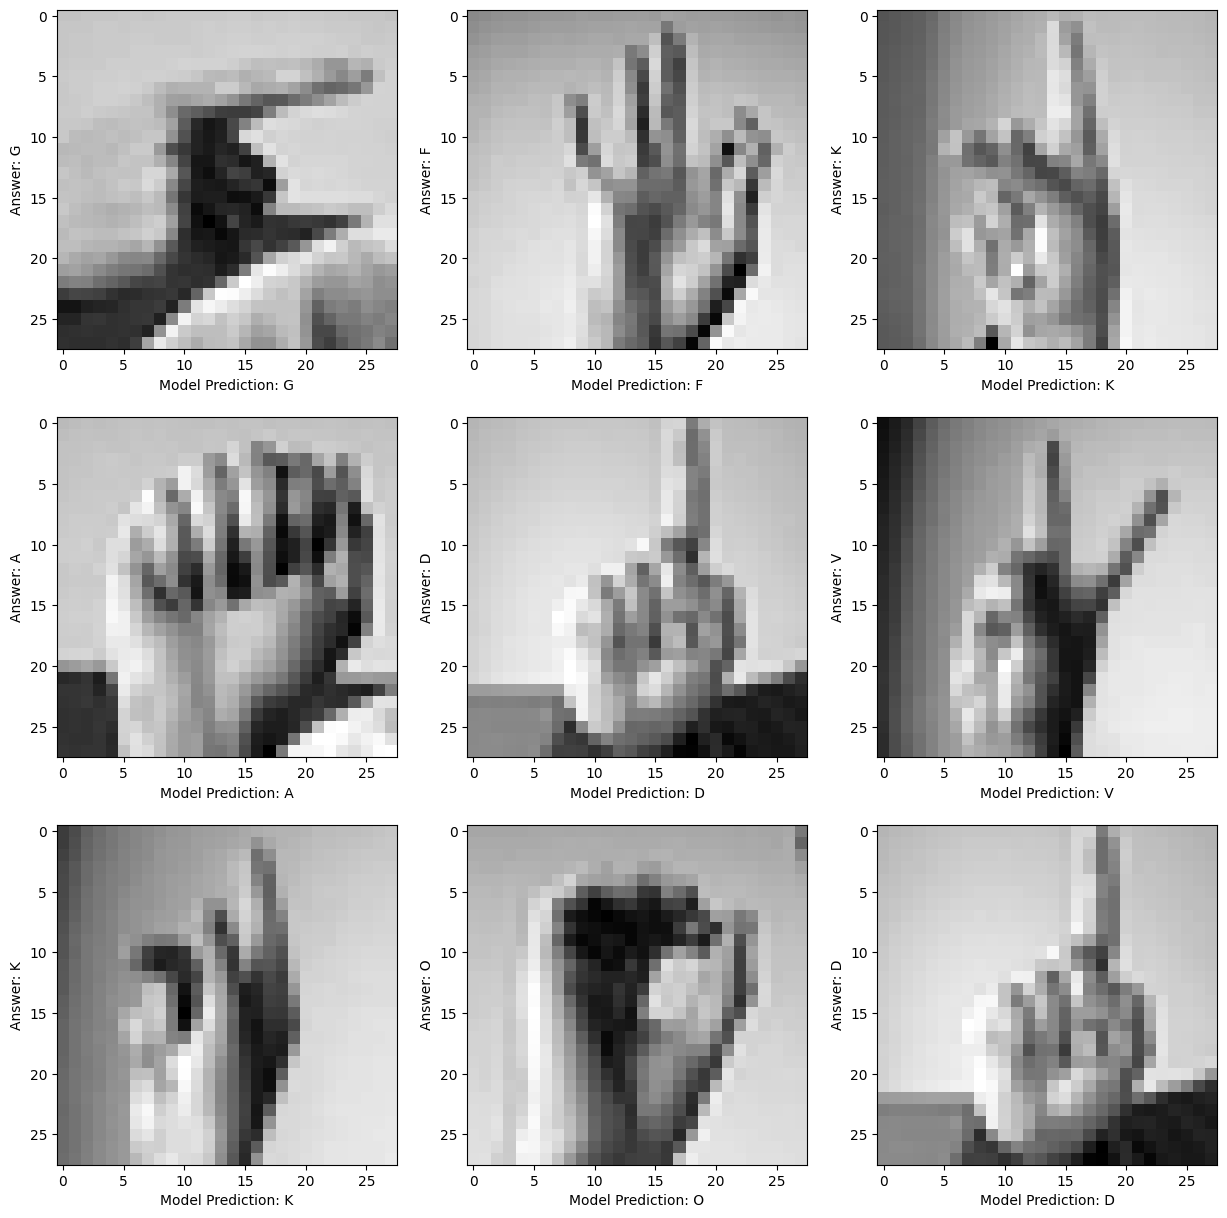

In [23]:
y_pred = np.argmax(Model.predict(X_test),axis=1)
plt.figure(figsize=(15,15))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[i],cmap='gray')
    plt.ylabel(f"Answer: {characters[y_test[i]]}")
    plt.xlabel(f"Model Prediction: {characters[y_pred[i]]}")
    
plt.show()